# Advanced Lane Finding Project

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Camera Calibration 

The **calibration.py** shows how to compute the distortion coefficients using OpenCV:
- There are 9x6=48 point located on the chessboard. (line 13)
- Assuming these object points in the world coordinates are (0,0,0), (1,0,0),...,(8,5,0), which lie on the plane z=0. (line 18)
- I detect these point in image coordinates calling `cv2.findChessboardCorners`. (line 23)
- The distortion coefficients can be computed by applying `cv2.calibrateCamera` to `objpoints` and `imgpoints`. (line 29)

In [2]:
import calibration
ret, mtx, dist, rvecs, tvecs = calibration.calibrate('camera_cal/calibration*.jpg')

** The followings shows the original image compared with distortion correction applied: **

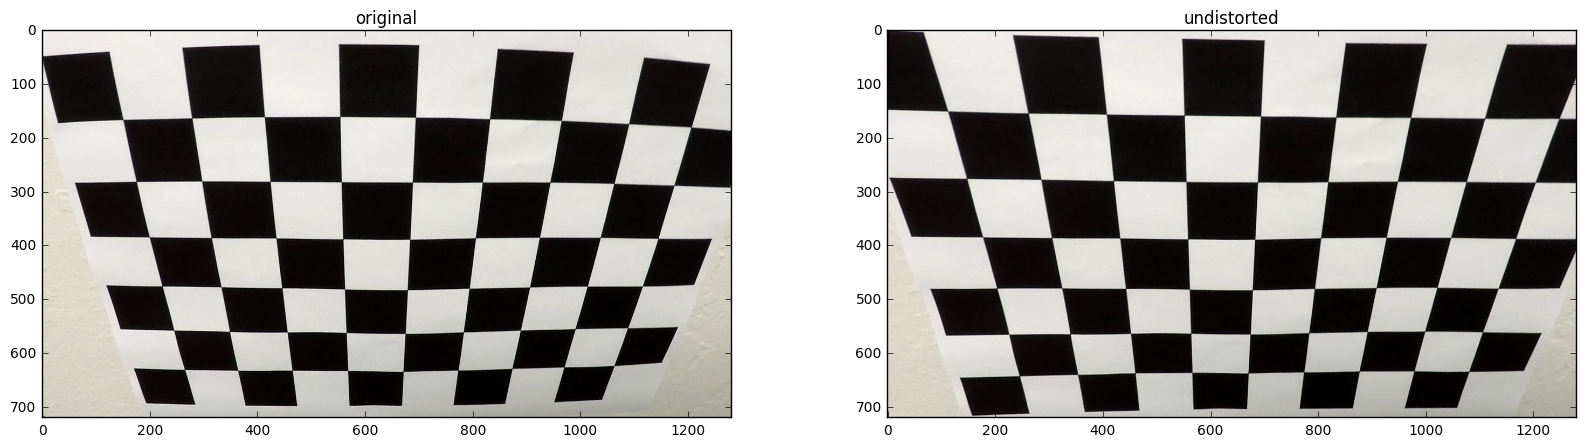

In [3]:
img_file = 'camera_cal/calibration2.jpg'
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(img, mtx, dist, None, mtx)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('original')
ax[0].imshow(img)
ax[1].set_title('undistorted')
ax[1].imshow(undist)

### Pipeline (single images)

** Distortion correction **

I apply the distortion correction to one of the test images like this one:

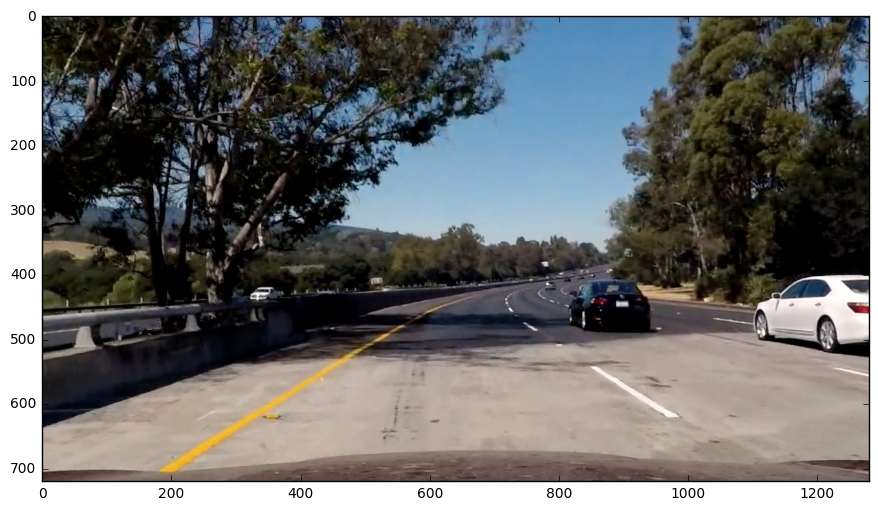

In [4]:
test_file = 'test_images/test5.jpg'
test_img = cv2.imread(test_file)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undist_test_img = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.figure(figsize=(20,6))
plt.imshow(undist_test_img)

** Output the binary image **

I combined the color transform and gradient filter and thresholded the output to generate the binary image. The functions are implented in ** process.py **, where:

- `undistort` computes the distortion-corrected image with the previous parameters `dist` and `mtx`.
- `sobel_abs` computes the the gradients in the horizontal/ vertical direction.
- `sobel_dir` computes the the angle of the gradient
- `thresh` computes the binary image by applying threshold to the previous outputs

** The following shows a example ouput by combining the above mentioned functions: **

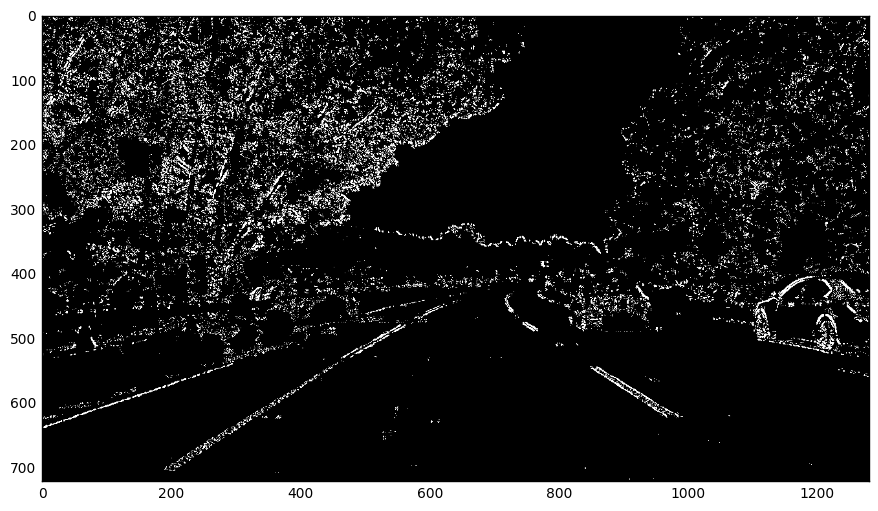

In [5]:
from process import undistort, sobel_abs, sobel_dir, thresh

filename = 'test_images/test5.jpg'
img = cv2.imread(filename)
undist_img = undistort(img, dist, mtx)
hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
saturation = hls[...,2]
gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
gradx = sobel_abs(gray, (20,255), 3)
grady = sobel_abs(gray, (20,255), 3, (0,1))
dir_bin = sobel_dir(gray,(0.5,1.0),3)
sat_bin = thresh(saturation, (180,255))

combined = np.zeros_like(dir_bin)
cond = ( (sat_bin == 1) & (dir_bin == 1) ) | ( (gradx == 1) & (grady == 1) )
combined[cond] = 1
plt.figure(figsize=(20,6))
plt.imshow(combined, cmap='gray')

** Perspective transfom **
Assuming the 4 points lie on the plane and the plane is flat, I chose the points as following:

Source|Destination   
---|---
 619, 435 | 280, 0
 659, 435 | 1025, 0
 1025, 674| 1025, 720
 280, 674| 280, 720

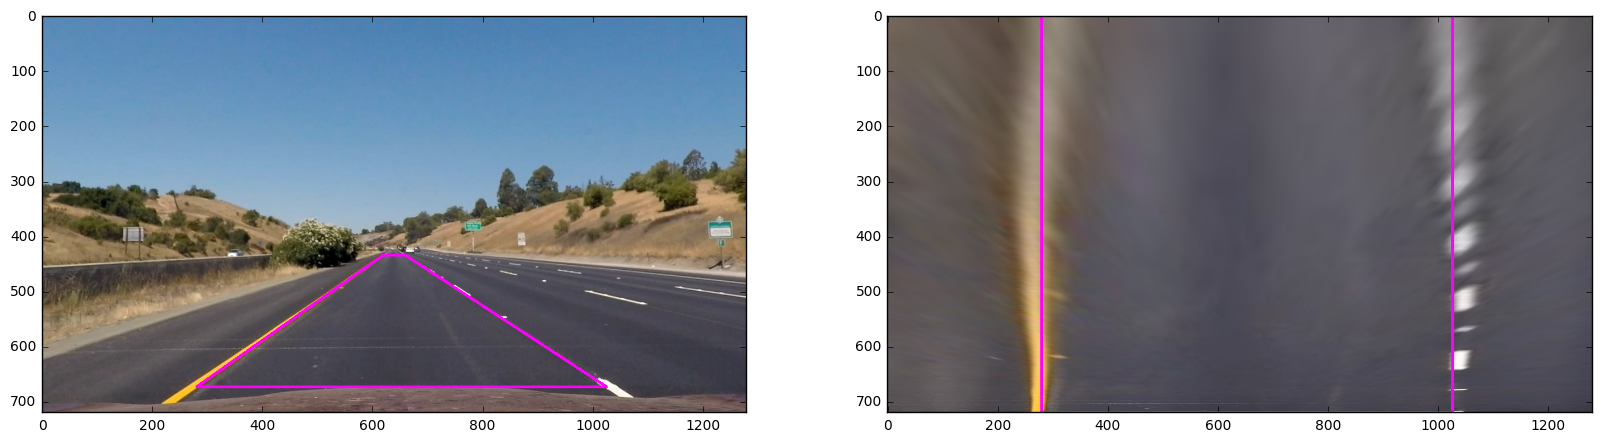

In [22]:
src = np.float32([[619,435],[659,435],[1025,674],[280,674]])
dst = np.float32([[280,0],[1025,0],[1025,720],[280,720]])

filename = 'test_images/straight_lines1.jpg'
img = cv2.imread(filename)
undist_img = undistort(img, dist, mtx)

transform = cv2.getPerspectiveTransform(src, dst)
warp = cv2.warpPerspective(undist_img, transform, combined.shape[::-1], flags=cv2.INTER_LINEAR)

undist_img_drawn = np.copy(undist_img)
cv2.polylines(undist_img_drawn, [src.astype(np.int32)], True, (255,0,255), 3)

warp_drawn = np.copy(warp)
cv2.polylines(warp_drawn, [dst.astype(np.int32)], True, (255,0,255), 3)

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1.imshow(undist_img_drawn)

ax2 = plt.subplot(122)
ax2.imshow(warp_drawn)